In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [625]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

# predictor = Predictor.pred_entropy_single


In [626]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:
training = False
save_probabilities = False
loadInference = False


# dataset = ParaDeforestationTime()
addPastDeforestationInput = True
'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = ParaMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 50


if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?

		exp = 90 # good result. label ok. f1 84.4 train 2018-2019
		exp = 92 # train 2017-2018
		exp = 93 # train 2016-2018
		exp = 94 # train 2015-2018
		
		exp = 96 # train 2018-2019
		exp = 97 # train 2017-2018
		exp = 98 # train 2016-2018
		exp = 99 # train 2015-2018


		exp = 122


		# train 2017-2018
		# exp = 138
		# exp = 140
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

		# exp = 88 adds project past deforestation to label
		exp = 89 # ok label. so so result
		
		exp = 91 # ok label. Good result. 81.8 F1. train 2019-2020
		exp = 95 # train 2018-2019
		exp = 100 # train 2017-2019
		exp = 101 # train 2016-2019
		exp = 102 # train 2016-2019
		
		# train 2018-2019
		exp = 137

		exp = 116
		
else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp

121

In [7]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [10]:
# np.save('label_not_independent.npy', label_mask)


In [11]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [14]:
label_mask.dtype

dtype('uint8')

In [15]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [16]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

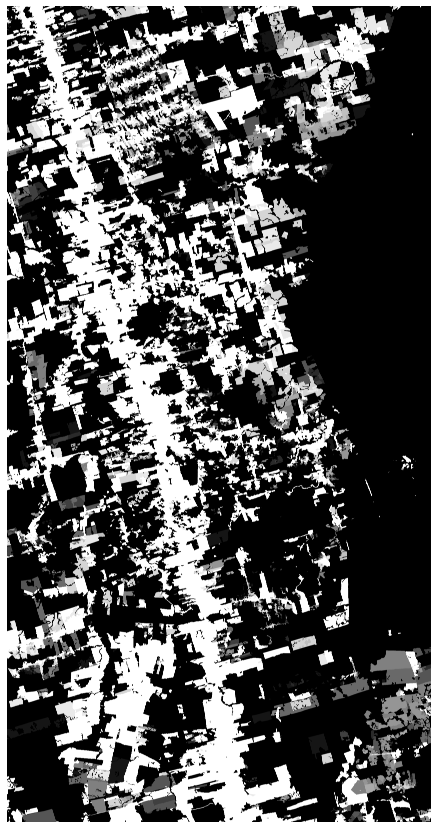

In [17]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [18]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [19]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [20]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [21]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [22]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

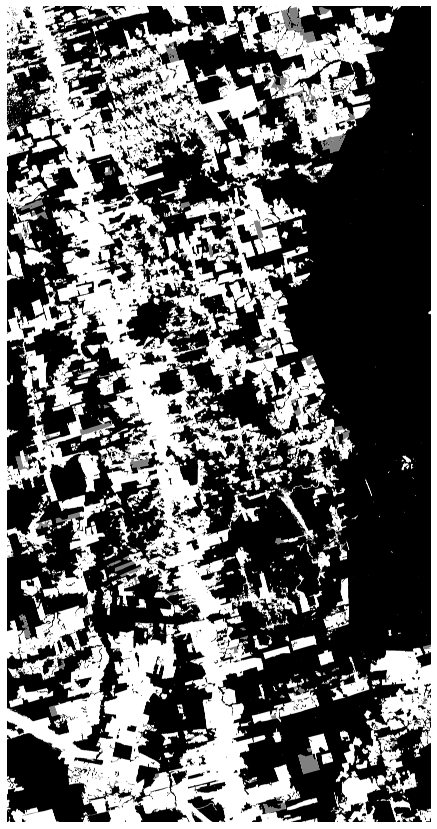

In [23]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [24]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [25]:
if training == True:
    print(coords_train)

In [26]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [27]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [28]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [29]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [30]:
inputSnipShow = False

In [31]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [33]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [35]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [36]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [37]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [38]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [39]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [40]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp121'

In [41]:
channels

21

In [42]:
image_stack.shape

(17730, 9200, 21)

In [43]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = loss.weighted_categorical_crossentropy(weights)
        
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [44]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

In [45]:
image_stack.shape

(17730, 9200, 21)

In [46]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [47]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [48]:
image_stack.shape

(17730, 9200, 21)

In [49]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [50]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp121/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
time:  10
time:  11
time:  12
time:  13
time:  14
time:  15
time:  16
time:  17
time:  18
time:  19
time:  20
time:  21
time:  22
time:  23
time:  24
time:  25
time:  26
time:  27
time:  28
time:  29
time:  30
time:  31
time:  32
time:  33
time:  34
time:  35
time:  36
time:  37
time:  38
time:  39
time:  40
time:  41
time:  42
time:  43
time:  44
time:  45
time:  46
time:  47
time:  48
time:  49


In [51]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [52]:
del image1_pad


In [53]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [54]:
# prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
prob_rec.shape



(17760, 9216, 50)

In [55]:
# prob_rec = np.transpose(prob_rec, (2, 0, 1))
# prob_rec = np.expand_dims(prob_rec, axis=-1)

In [484]:

if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


ic| reducedInferenceRuns: 5


In [485]:
prob_rec.shape

(17760, 9216, 5)

In [486]:
prob_rec.shape

(17760, 9216, 5)

In [487]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [488]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 3.6473993e-15
    np.mean(mean_prob): 0.01613573
    np.max(mean_prob): 0.9972531


(3.6473993e-15, 0.01613573, 0.9972531)

In [489]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [490]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

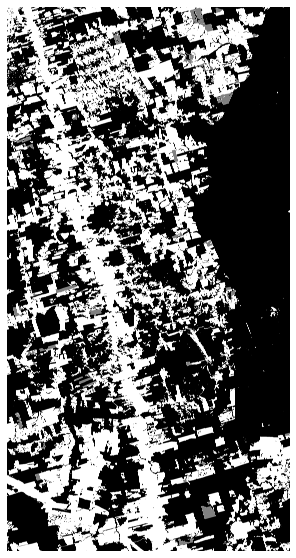

In [491]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [492]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [493]:
mean_prob.shape

(17730, 9200)

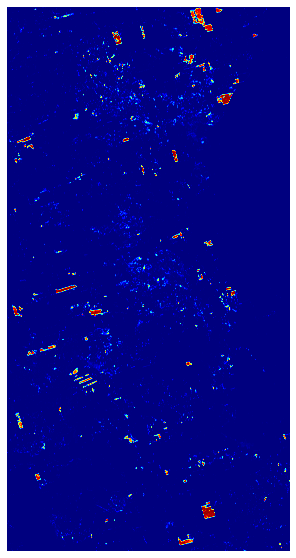

In [494]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [495]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [496]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54118363,)
(array([0, 1], dtype=uint8), array([53386768,   731595], dtype=int64))


In [497]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

90.34


In [498]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 5)


In [499]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [500]:
ic(prob_rec.shape)

ic| prob_rec.shape: (5, 17760, 9216, 1)


(5, 17760, 9216, 1)

In [501]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [502]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 4.3551887e-28
    np.mean(prob_rec): 0.016135816
    np.max(prob_rec): 0.99975234
ic| prob_rec.shape: (5, 17760, 9216, 1)


(5, 17760, 9216, 1)

In [503]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (17760, 9216)
ic| n: 5, K: 1


In [504]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [505]:
np.mean(KL)

0.0025351956

In [506]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [507]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0114662405
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 1.2037318e-13
    np.mean(pred_entropy): 0.0130917
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [508]:
prob_rec.shape

(5, 17760, 9216, 1)

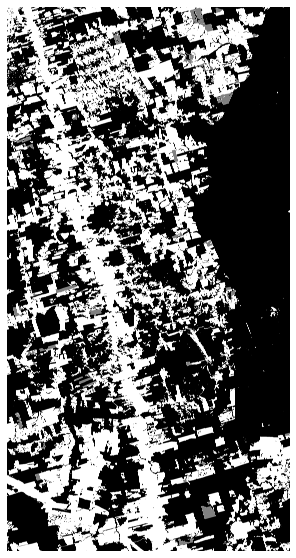

In [509]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [510]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

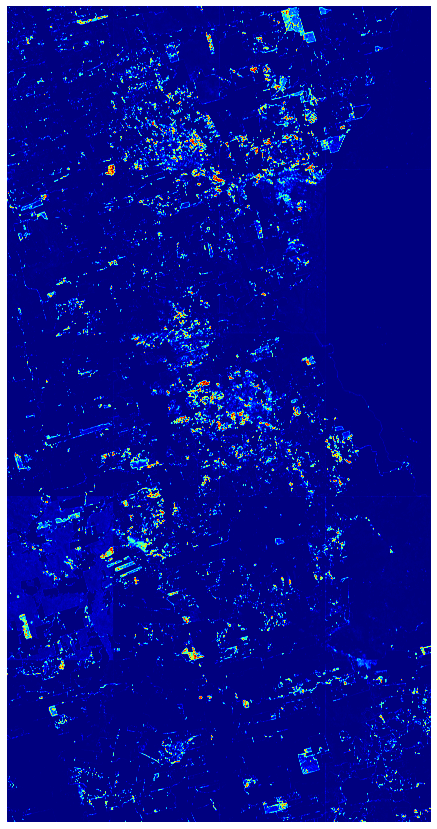

In [511]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

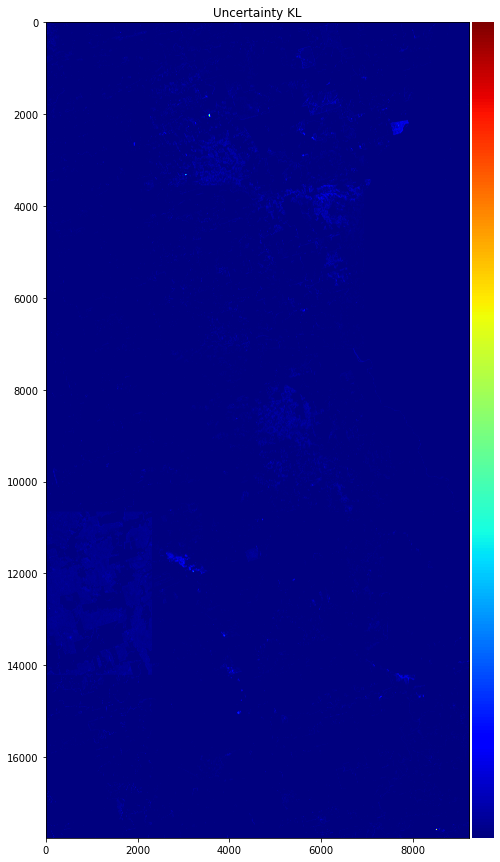

In [512]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

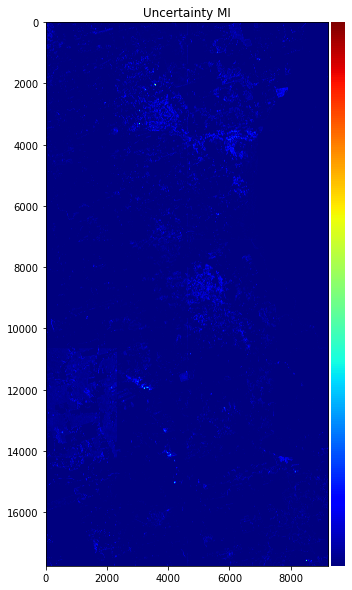

In [513]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

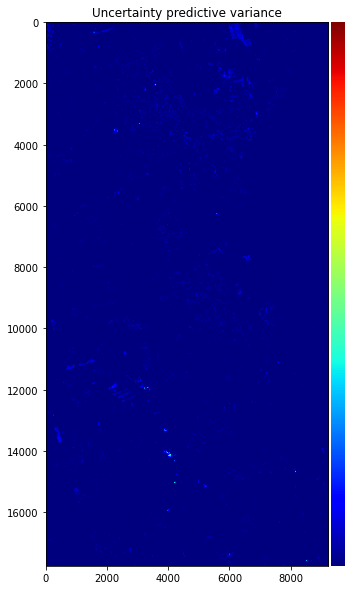

In [514]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [515]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

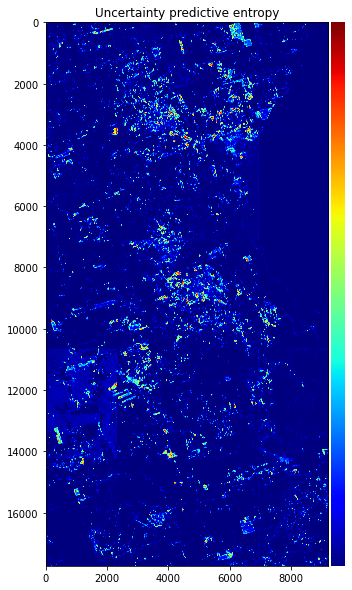

In [516]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [517]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (5, 17760, 9216, 1)
ic| np.min(prob_rec): 4.3551887e-28
    np.mean(prob_rec): 0.016135816
    np.max(prob_rec): 0.99975234


(4.3551887e-28, 0.016135816, 0.99975234)

In [518]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [519]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


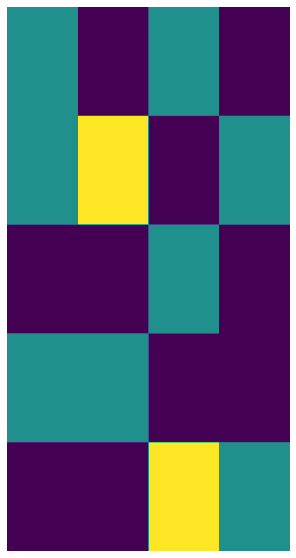

In [520]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [521]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [522]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1771167, 161344833], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1771167, 161344833], dtype=int64))

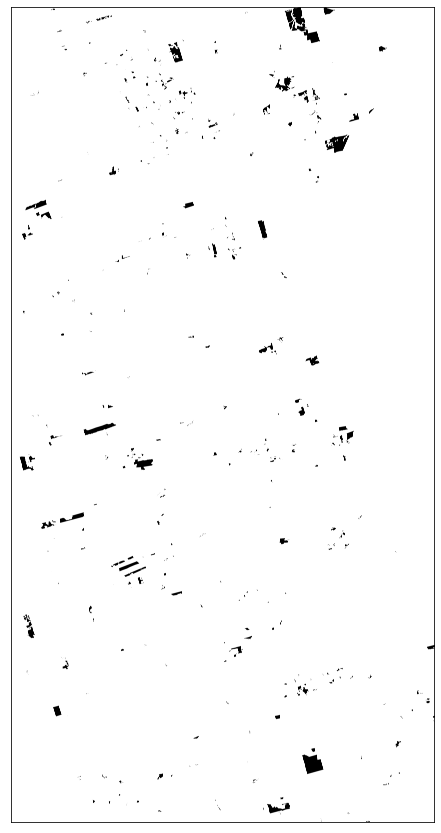

In [523]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [524]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9422241,)


(9422241,)

In [525]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [526]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.531990, F-Score=0.875


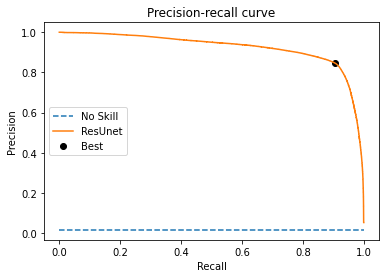

In [527]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [627]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

if predictor != Predictor.pred_entropy_single:
    predicted[mean_prob>=threshold] = 1
    predicted[mean_prob<threshold] = 0
else:
    print("Single entropy")
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
Single entropy
(array([0., 1.], dtype=float32), array([160976982,   2139018], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [628]:
threshold

0.5

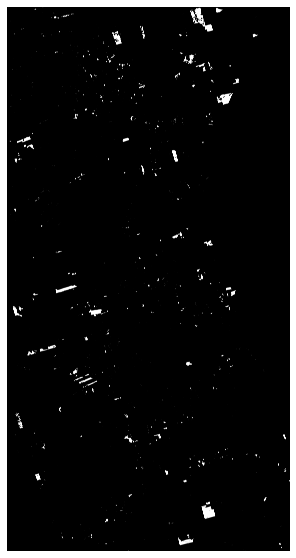

In [629]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [630]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [631]:
# mean_prob_unpad.shape

In [632]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [633]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [634]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [635]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [636]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [637]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54109852,)


(54109852,)

In [638]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161323170,   1792830], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161387892,   1728108], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163051278,     64722], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53355716,   726325, 27475959], dtype=int64))
ic| predicted_masked.shape: (54082041,)
    label_masked.shape: (54082041,)


In [639]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [640]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 85.4, precision: 86.43, recall: 84.39


(85.4, 86.43, 84.39)

### Metrics for validation set in forest/deforestation detection

In [641]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [642]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [643]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 87.45
    precision_val: 84.4
    recall_val: 90.73
    mAP_val: 92.38


(87.45, 84.4, 90.73, 92.38)

In [644]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [645]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162559547,    556453], dtype=int64))


In [646]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   299756, 162559547,    256697], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   299756, 162559547,    256697], dtype=int64))

In [647]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [648]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

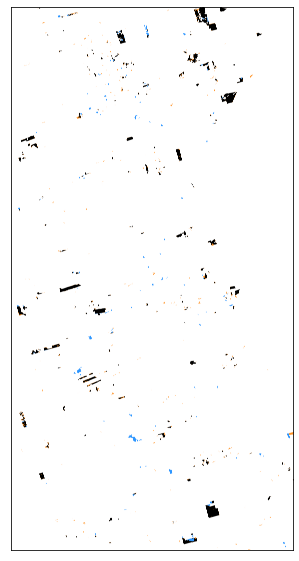

In [649]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


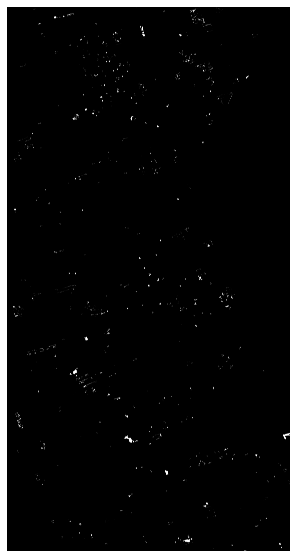

In [650]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [651]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54082041,)


(54082041,)

In [652]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [653]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [654]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [655]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [656]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [657]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


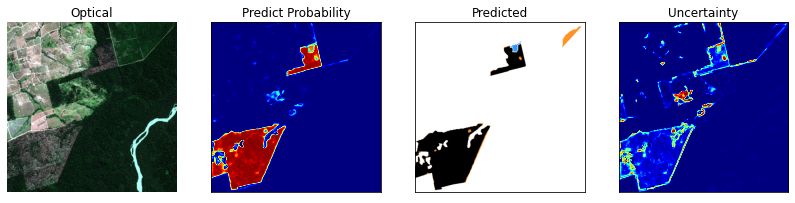

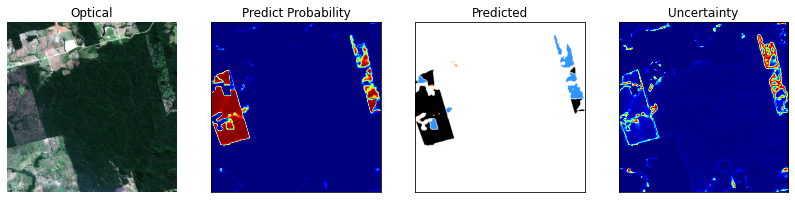

In [658]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [659]:

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [660]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 6.574546e-14
    np.mean(uncertainty): 0.013805577
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 1.2037318e-13
    np.mean(pred_entropy): 0.0130917
    np.max(pred_entropy): 0.36787948


(1.2037318e-13, 0.0130917, 0.36787948)

In [661]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54082041,), uncertainty.shape: (54082041,)
ic| roc_auc: 0.9534883085697973


0.9534883085697973

Best Threshold=0.002150, G-Mean=0.912


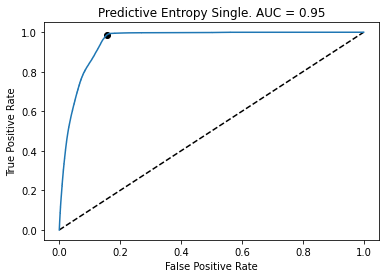

In [662]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [663]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.002149768


In [664]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [665]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [666]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [667]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [668]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [669]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [670]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [671]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [672]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [673]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [674]:
ic(thresholds)

ic| thresholds: array([0.00000001, 0.00000001, 0.00000001, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00000001, 0.00000001, 0.00000001, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [675]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.269292, F-Score=0.194


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_9500\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


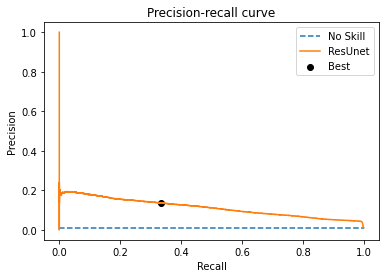

In [676]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [677]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [678]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 6.574546e-14
    np.average(uncertainty): 0.013805577
    np.max(uncertainty): 0.36787948


(6.574546e-14, 0.013805577, 0.36787948)

In [679]:
# plt.hist(uncertainty)

In [680]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [681]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54082041,)
    label_mask_current_deforestation_test.shape: (54082041,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [682]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 6.574546e-14
    np.mean(uncertainty): 0.013805577
    np.max(uncertainty): 0.36787948


(6.574546e-14, 0.013805577, 0.36787948)

In [683]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54082041,)


(54082041,)

In [684]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52302148,  1779893], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100659414,   1753671,  60702915], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52302148,  1779893], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100659414,   1753671,  60702915], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [685]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.03291098056007169


0.03291098056007169

In [686]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.03291098056007169


0.03291098056007169

In [687]:
predictor

<Predictor.pred_entropy_single: 5>

In [688]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54082041,)
    label_mask_current_deforestation_test.shape: (54082041,)


[0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.0025
(40431327,) (40431327,)


ic| label_current_deforestation_test_classified_incorrect.shape: (13650714,)
    predicted_test_classified_incorrect.shape: (13650714,)


cm_correct [[40423743        0]
 [    7139      445]]


ic| TP_H + FN_H + FP_H + TN_H: 13650714
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 13650714
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[12835769    96204]
 [  106214   612527]]
[1.         0.05867616 0.00061267 0.25240752 0.86425879 0.85222215]
threshold 0.005
(44351576,) (44351576,)


ic| label_current_deforestation_test_classified_incorrect.shape: (9730465,)
    predicted_test_classified_incorrect.shape: (9730465,)


cm_correct [[44337587        0]
 [    9096     4893]]


ic| TP_H + FN_H + FP_H + TN_H: 9730465
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 9730465
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[8921925   96204]
 [ 104257  608079]]
[1.         0.34977482 0.00673665 0.17992045 0.8634015  0.8536407 ]
threshold 0.0075
(46384262,) (46384262,)


ic| label_current_deforestation_test_classified_incorrect.shape: (7697779,)
    predicted_test_classified_incorrect.shape: (7697779,)


cm_correct [[46357136        0]
 [   10088    17038]]


ic| TP_H + FN_H + FP_H + TN_H: 7697779
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 7697779
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[6902376   96204]
 [ 103265  595934]]
[1.         0.62810588 0.02345782 0.14233522 0.8610046  0.85230957]
threshold 0.01
(47467337,) (47467337,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6614704,)
    predicted_test_classified_incorrect.shape: (6614704,)


cm_correct [[47415917        1]
 [   10702    40717]]


ic| TP_H + FN_H + FP_H + TN_H: 6614704
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 6614704
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[5843595   96203]
 [ 102651  572255]]
[0.99997544 0.79186682 0.05605893 0.1223087  0.85608221 0.84790326]
threshold 0.015
(48542407,) (48542407,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5539634,)
    predicted_test_classified_incorrect.shape: (5539634,)


cm_correct [[48431648       74]
 [   11625    99060]]


ic| TP_H + FN_H + FP_H + TN_H: 5539634
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 5539634
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[4827864   96130]
 [ 101728  513912]]
[0.99925354 0.89497222 0.13638523 0.10243019 0.84242069 0.83476057]
threshold 0.025
(49536787,) (49536787,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4545254,)
    predicted_test_classified_incorrect.shape: (4545254,)


cm_correct [[49327329      632]
 [   13000   195826]]


ic| TP_H + FN_H + FP_H + TN_H: 4545254
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 4545254
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[3932183   95572]
 [ 100353  417146]]
[0.99678303 0.93774722 0.26961209 0.08404368 0.81359734 0.80608078]
threshold 0.05
(50703260,) (50703260,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3378781,)
    predicted_test_classified_incorrect.shape: (3378781,)


cm_correct [[50371485     4443]
 [   15422   311910]]


ic| TP_H + FN_H + FP_H + TN_H: 3378781
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 3378781
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[2888027   91761]
 [  97931  301062]]
[0.98595556 0.95288576 0.42943586 0.0624751  0.76640624 0.75455459]
threshold 0.08
(51412632,) (51412632,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2669409,)
    predicted_test_classified_incorrect.shape: (2669409,)


cm_correct [[51002403    10683]
 [   18206   381340]]


ic| TP_H + FN_H + FP_H + TN_H: 2669409
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 2669409
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[2257109   85521]
 [  95147  231632]]
[0.97274905 0.95443328 0.52502668 0.04935851 0.73034781 0.7088338 ]
threshold 0.1
(51736060,) (51736060,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2345981,)
    predicted_test_classified_incorrect.shape: (2345981,)


cm_correct [[51283463    15302]
 [   20134   417161]]


ic| TP_H + FN_H + FP_H + TN_H: 2345981
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 2345981
    len(label_mask_current_deforestation_test): 54082041


cm_incorrect [[1976049   80902]
 [  93219  195811]]
[0.96461663 0.95395785 0.57434482 0.04337819 0.7076321  0.67747639]
threshold 0.15
(52302148,) (52302148,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1779893,)
    predicted_test_classified_incorrect.shape: (1779893,)
ic

cm_correct [[51769284    27927]
 [   24876   480061]]
cm_incorrect [[1490228   68277]
 [  88477  132911]]


| TP_H + FN_H + FP_H + TN_H: 1779893
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 1779893
    len(label_mask_current_deforestation_test): 54082041


[0.94502429 0.95073445 0.66094517 0.03291098 0.66063085 0.60035323]
threshold 0.2
(52706350,) (52706350,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1375691,)
    predicted_test_classified_incorrect.shape: (1375691,)
ic| TP_H + FN_H + FP_H 

cm_correct [[52113524    41216]
 [   30263   521347]]
cm_incorrect [[1145988   54988]
 [  83090   91625]]


+ TN_H: 1375691
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 1375691
    len(label_mask_current_deforestation_test): 54082041


[0.92673532 0.94513696 0.71778749 0.02543711 0.62494458 0.52442549]
threshold 0.225
(52878780,) (52878780,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1203261,)
    predicted_test_classified_incorrect.shape: (1203261,)
ic| TP_H + FN_H + FP_H + TN_H: 1203261
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 1203261
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[52258625    47858]
 [   33136   539161]]
cm_incorrect [[1000887   48346]
 [  80217   73811]]
[0.91847283 0.94209999 0.7423137  0.02224881 0.60423062 0.47920508]
threshold 0.25
(53040640,) (53040640,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1041401,)
    predicted_test_classified_incorrect.shape: (1041401,)
ic| TP_H + FN_H + FP_H + TN_H: 1041401
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 1041401
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[52393240    55293]
 [   36398   555709]]
cm_incorrect [[866272  40911]
 [ 76955  57263]]
[0.90950439 0.938528   0.76509689 0.01925595 0.58328071 0.42664173]
threshold 0.27
(53166843,) (53166843,)


ic| label_current_deforestation_test_classified_incorrect.shape: (915198,)
    predicted_test_classified_incorrect.shape: (915198,)
ic| TP_H + FN_H + FP_H + TN_H: 915198
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 915198
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[52497524    62058]
 [   39460   567801]]
cm_incorrect [[761988  34146]
 [ 73893  45171]]
[0.90147319 0.9350197  0.78174509 0.0169224  0.5694996  0.3793842 ]
threshold 0.3
(53354723,) (53354723,)


ic| label_current_deforestation_test_classified_incorrect.shape: (727318,)
    predicted_test_classified_incorrect.shape: (727318,)
ic| TP_H + FN_H + FP_H + TN_H: 727318
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 727318
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[52650643    73575]
 [   45120   585385]]
cm_incorrect [[608869  22629]
 [ 68233  27587]]
[0.88834679 0.92843832 0.80595463 0.01344842 0.54936674 0.2879044 ]
threshold 0.34
(53630184,) (53630184,)


ic| label_current_deforestation_test_classified_incorrect.shape: (451857,)
    predicted_test_classified_incorrect.shape: (451857,)
ic| TP_H + FN_H + FP_H + TN_H: 451857
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 451857
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[52871951    92493]
 [   56920   608820]]
cm_incorrect [[387561   3711]
 [ 56433   4152]]
[0.86811452 0.91450116 0.83821981 0.00835503 0.52804273 0.06853181]
threshold 0.36
(53845754,) (53845754,)


ic| label_current_deforestation_test_classified_incorrect.shape: (236287,)
    predicted_test_classified_incorrect.shape: (236287,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 236287
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 236287
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[53055616    96204]
 [   80962   612972]]
cm_incorrect [[203896      0]
 [ 32391      0]]
[0.86434397 0.88332896 0.84393625 0.00436905        nan 0.        ]
threshold 0.3648794801235199
(53937708,) (53937708,)


ic| label_current_deforestation_test_classified_incorrect.shape: (144333,)
    predicted_test_classified_incorrect.shape: (144333,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 144333
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 144333
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[53135137    96204]
 [   93395   612972]]
cm_incorrect [[124375      0]
 [ 19958      0]]
[0.86434397 0.8677812  0.84393625 0.00266878        nan 0.        ]
threshold 0.3663794801235199
(53980256,) (53980256,)


ic| label_current_deforestation_test_classified_incorrect.shape: (101785,)
    predicted_test_classified_incorrect.shape: (101785,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 101785
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 101785
    len(label_mask_current_deforestation_test): 54082041


cm_correct [[53171772    96204]
 [   99308   612972]]
cm_incorrect [[87740     0]
 [14045     0]]
[0.86434397 0.8605773  0.84393625 0.00188205        nan 0.        ]


In [689]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54082041,)
    label_mask_current_deforestation_test.shape: (54082041,)


threshold 0.0025
(54082041,) (54082041,)
cm_audited [[53355716        0]
 [    7139   719186]]
[1.         0.99017107]
threshold 0.005
(54082041,) (54082041,)
cm_audited [[53355716        0]
 [    9096   717229]]
[1.         0.98747668]
threshold 0.0075
(54082041,) (54082041,)
cm_audited [[53355716        0]
 [   10088   716237]]
[1.        0.9861109]
threshold 0.01
(54082041,) (54082041,)
cm_audited [[53355715        1]
 [   10702   715623]]
[0.9999986  0.98526555]
threshold 0.015
(54082041,) (54082041,)
cm_audited [[53355642       74]
 [   11625   714700]]
[0.99989647 0.98399477]
threshold 0.025
(54082041,) (54082041,)
cm_audited [[53355084      632]
 [   13000   713325]]
[0.99911479 0.98210168]
threshold 0.05
(54082041,) (54082041,)
cm_audited [[53351273     4443]
 [   15422   710903]]
[0.99378902 0.97876708]
threshold 0.08
(54082041,) (54082041,)
cm_audited [[53345033    10683]
 [   18206   708119]]
[0.98513777 0.97493409]
threshold 0.1
(54082041,) (54082041,)
cm_audited [[53340414

ic| metric_values_audited: array([[1.        , 0.99017107],
                                  [1.        , 0.98747668],
                                  [1.        , 0.9861109 ],
                                  [0.9999986 , 0.98526555],
                                  [0.99989647, 0.98399477],
                                  [0.99911479, 0.98210168],
                                  [0.99378902, 0.97876708],
                                  [0.98513777, 0.97493409],
                                  [0.9787912 , 0.97227963],
                                  [0.96171111, 0.96575087],
                                  [0.94409707, 0.95833408],
                                  [0.9354184 , 0.95437855],
                                  [0.92580312, 0.94988745],
                                  [0.91713701, 0.9456717 ],
                                  [0.90252126, 0.93787905],
                                  [0.87860186, 0.92163288],
                                  [0.870

cm_audited [[53259512    96204]
 [   99308   627017]]
[0.86697842 0.86327333]


In [690]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [691]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [692]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [693]:
save_figures = True

In [694]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

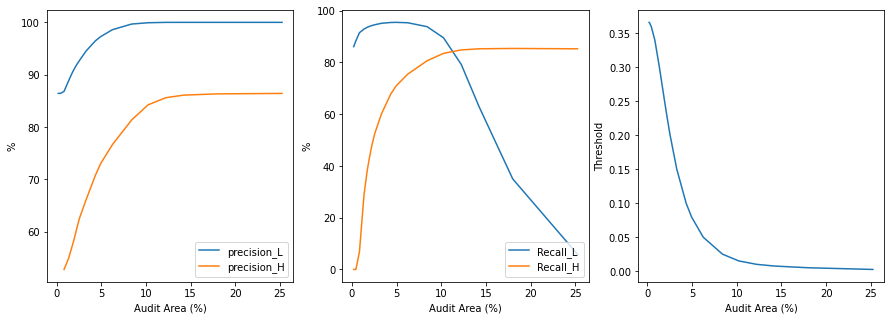

In [695]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [696]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


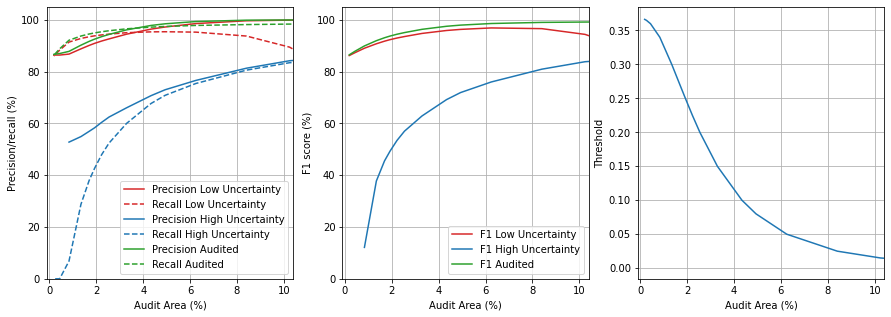

In [697]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [698]:


m

{'precision_L': array([1.        , 1.        , 1.        , 0.99997544, 0.99925354,
        0.99678303, 0.98595556, 0.97274905, 0.96461663, 0.94502429,
        0.92673532, 0.91847283, 0.90950439, 0.90147319, 0.88834679,
        0.86811452, 0.86434397, 0.86434397, 0.86434397]),
 'recall_L': array([0.05867616, 0.34977482, 0.62810588, 0.79186682, 0.89497222,
        0.93774722, 0.95288576, 0.95443328, 0.95395785, 0.95073445,
        0.94513696, 0.94209999, 0.938528  , 0.9350197 , 0.92843832,
        0.91450116, 0.88332896, 0.8677812 , 0.8605773 ]),
 'recall_Ltotal': array([0.00061267, 0.00673665, 0.02345782, 0.05605893, 0.13638523,
        0.26961209, 0.42943586, 0.52502668, 0.57434482, 0.66094517,
        0.71778749, 0.7423137 , 0.76509689, 0.78174509, 0.80595463,
        0.83821981, 0.84393625, 0.84393625, 0.84393625]),
 'AA': array([0.25240752, 0.17992045, 0.14233522, 0.1223087 , 0.10243019,
        0.08404368, 0.0624751 , 0.04935851, 0.04337819, 0.03291098,
        0.02543711, 0.022248

In [699]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 0.9999986 , 0.99989647,
        0.99911479, 0.99378902, 0.98513777, 0.9787912 , 0.96171111,
        0.94409707, 0.9354184 , 0.92580312, 0.91713701, 0.90252126,
        0.87860186, 0.87026931, 0.86805717, 0.86697842]),
 'recall': array([0.99017107, 0.98747668, 0.9861109 , 0.98526555, 0.98399477,
        0.98210168, 0.97876708, 0.97493409, 0.97227963, 0.96575087,
        0.95833408, 0.95437855, 0.94988745, 0.9456717 , 0.93787905,
        0.92163288, 0.88853199, 0.87141431, 0.86327333]),
 'f1': array([0.99506126, 0.99369888, 0.99300689, 0.99257741, 0.99188189,
        0.99053519, 0.98622085, 0.98000937, 0.97552455, 0.96372675,
        0.9511623 , 0.94480336, 0.93769066, 0.93118581, 0.91986051,
        0.89960308, 0.87930583, 0.8697325 , 0.86512191])}

In [700]:
exp

121

In [701]:
threshold_list

[0.0025,
 0.005,
 0.0075,
 0.01,
 0.015,
 0.025,
 0.05,
 0.08,
 0.1,
 0.15,
 0.2,
 0.225,
 0.25,
 0.27,
 0.3,
 0.34,
 0.36,
 0.3648794801235199,
 0.3663794801235199]

In [702]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [703]:
predictor

<Predictor.pred_entropy_single: 5>

In [726]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs
if predictor == Predictor.pred_entropy:
        if exp == 90:
                threshold_list2 = [0.14]
        elif exp == 91:
                threshold_list2 = [0.16]
        elif exp == 92:
                threshold_list2 = [0.125]
        elif exp == 93:
                threshold_list2 = [0.13]
        elif exp == 94:
                threshold_list2 = [0.217]
        elif exp == 95:
                threshold_list2 = [0.217]
        elif exp == 96:
                threshold_list2 = [0.115]
        elif exp == 97:
                threshold_list2 = [0.127]
        elif exp == 98:
                threshold_list2 = [0.133]
        elif exp == 99:
                threshold_list2 = [0.197]
        elif exp == 100:
                threshold_list2 = [0.112]
        elif exp == 101:
                threshold_list2 = [0.101]
        elif exp == 102:
                threshold_list2 = [0.05]

        elif exp == 103:
                threshold_list2 = [0.13]
                # threshold_list2 = [0.157]
                
                # threshold_list2 = [0.1405]
                # threshold_list2 = [0.141]

        elif exp == 104:
                threshold_list2 = [0.173]
                # threshold_list2 = [0.16]

        elif exp == 105:
                threshold_list2 = [0.11]
                threshold_list2 = [0.114]
                threshold_list2 = [0.12]
                threshold_list2 = [0.114]
                threshold_list2 = [0.112]

        elif exp == 106:
                threshold_list2 = [0.159]
                threshold_list2 = [0.173]
                threshold_list2 = [0.167]

        elif exp == 107:
                threshold_list2 = [0.238]
                threshold_list2 = [0.2415]
                threshold_list2 = [0.238]


        # MT
        elif exp == 108:
                threshold_list2 = [0.112] # 0.1, 0.15
                threshold_list2 = [0.103]
                threshold_list2 = [0.106] # 0.1, 0.15
                threshold_list2 = [0.114] # 0.1, 0.15
                threshold_list2 = [0.104]
                
        elif exp == 109:
                threshold_list2 = [0.1113] # 0.1, 0.15
                threshold_list2 = [0.109] # 0.1, 0.15
                threshold_list2 = [0.105] # 0.1, 0.15
                threshold_list2 = [0.103] # 0.1, 0.15
                threshold_list2 = [0.086] # 0.1, 0.15

        elif exp == 110:
                threshold_list2 = [0.128] # 0.1, 0.15
                threshold_list2 = [0.123] # 0.1, 0.15
                threshold_list2 = [0.121] # 0.1, 0.15
                threshold_list2 = [0.132] # 0.1, 0.15


        elif exp == 111:
                threshold_list2 = [0.077] # 0.05, 0.08
                threshold_list2 = [0.093] # 0.05, 0.08
                threshold_list2 = [0.1] # 0.05, 0.08
                threshold_list2 = [0.082] # 0.05, 0.08
                threshold_list2 = [0.062] # 0.05, 0.08
                
        elif exp == 112:
#                 threshold_list2 = [0.084] # 0.08, 0.1
                threshold_list2 = [0.081] # 0.08, 0.1
                threshold_list2 = [0.083] # 0.08, 0.1
                threshold_list2 = [0.088] # 0.08, 0.1
                threshold_list2 = [0.085] # 0.08, 0.1

        elif exp == 113:
                threshold_list2 = [0.119] # 0.1, 0.15
                threshold_list2 = [0.121] # 0.1, 0.15
                threshold_list2 = [0.125] # 0.1, 0.15

        elif exp == 114:
                threshold_list2 = [0.0855] # 0.08, 0.1
                threshold_list2 = [0.089] # 0.08, 0.1
                # threshold_list2 = [0.093] # 0.08, 0.1
                threshold_list2 = [0.084] # 0.08, 0.1
                threshold_list2 = [0.0878] # 0.08, 0.1



        elif exp == 115:
                threshold_list2 = [0.088] # 0.08, 0.1
                threshold_list2 = [0.0915] # 0.08, 0.1
                threshold_list2 = [0.0897] # 0.08, 0.1
                threshold_list2 = [0.078] # 0.08, 0.1
                
        elif exp == 116:
                threshold_list2 = [0.126] # 0.1, 0.15
                threshold_list2 = [0.123] # 0.1, 0.15
                threshold_list2 = [0.112] # 0.1, 0.15

        elif exp == 117:
                threshold_list2 = [0.17] # 0.15, 0.2

        # PA
        elif exp == 118:
                threshold_list2 = [0.208] # 0.15, 0.2
                threshold_list2 = [0.216] # 0.15, 0.2
                threshold_list2 = [0.217] # 0.15, 0.2

        elif exp == 119:
                threshold_list2 = [0.123] # 0.1, 0.15
                threshold_list2 = [0.13] # 0.1, 0.15
                threshold_list2 = [0.132] # 0.1, 0.15
                threshold_list2 = [0.138] # 0.1, 0.15
                threshold_list2 = [0.136] # 0.1, 0.15

        elif exp == 120:
                threshold_list2 = [0.22] # 0.2, 0.225
                threshold_list2 = [0.214] # 0.2, 0.225
                threshold_list2 = [0.208] # 0.2, 0.225

        elif exp == 121:
                threshold_list2 = [0.1985] # 0.2
                threshold_list2 = [0.173] # 0.2
                threshold_list2 = [0.17] # 0.2
                threshold_list2 = [0.168] # 0.2

        elif exp == 122:
                threshold_list2 = [0.176] # 0.15, 0.2

        # T_-2, T_-1 PA
        elif exp == 123:
                threshold_list2 = [0.17] # 0.15, 0.2
        elif exp == 124:
                threshold_list2 = [0.168] # 0.15, 0.2
        elif exp == 125:
                threshold_list2 = [0.125] # 0.1, 0.15
        elif exp == 126:
                threshold_list2 = [0.185] # 0.15, 0.2
        elif exp == 127:
                threshold_list2 = [0.171] # 0.15, 0.2
        elif exp == 128:
                threshold_list2 = [0.103] # 0.1, 0.15
        elif exp == 129:
                threshold_list2 = [0.222] # 0.2, 0.225

        elif exp == 131:
                threshold_list2 = [0.115] # 0.1, 0.15

        # T_-2, T_-1 MT

        elif exp == 130:
                threshold_list2 = [0.227] # 0.225, 0.25
        elif exp == 132:
                threshold_list2 = [0.177] # 0.15, 0.2
        elif exp == 133:
                threshold_list2 = [0.14] # 0.1, 0.15
        elif exp == 134:
                threshold_list2 = [0.167] # 0.15, 0.25
        elif exp == 135:
                threshold_list2 = [0.1235] # 0.1, 0.15
        elif exp == 136:
                threshold_list2 = [0.168] # 0.1, 0.15
        elif exp == 137:
                threshold_list2 = [0.185] # 0.15, 0.2

        # repeating experiments. Para 2018-2019
        # threshold_list2 = [0.262]
        # threshold_list2 = [0.151]
        # threshold_list2 = [0.215]
        # threshold_list2 = [0.144]

elif  predictor == Predictor.pred_var:
        threshold_list2 = [0.00325] # 0.0027083333333333334, 0.003611111111111112
        threshold_list2 = [0.00227] # 0.001805555555555556, 0.0027083333333333334
        if exp == 103:
                threshold_list2 = [0.0024] # 0.001805555555555556, 0.0027083333333333334
        elif exp == 104:
                threshold_list2 = [0.00288] # 0.0027, 0.0036
        elif exp == 105:
                threshold_list2 = [0.00155] # 0.0009, 0.0018
        elif exp == 106:
                threshold_list2 = [0.00225] # 0.0018, 0.0027
        elif exp == 107:
                threshold_list2 = [0.005] # 0.0036, 0.0054

        # MT
        elif exp == 108:
                threshold_list2 = [0.00204] # 0.001805, 0.002708
        elif exp == 109:
                threshold_list2 = [0.00218] # 0.001805, 0.002708
        elif exp == 110:
                threshold_list2 = [0.00218] # 0.001805, 0.002708
        elif exp == 111:
                threshold_list2 = [0.00077] # <0.0009
        elif exp == 112:
                threshold_list2 = [0.00115] # 0.0009, 0.0018
        elif exp == 113:
                threshold_list2 = [0.00207] # 0.001805, 0.002708
        elif exp == 114:
                threshold_list2 = [0.00077] # <0.0009
        elif exp == 115:
                threshold_list2 = [0.0012] # 0.0009, 0.0018
        elif exp == 116:
                threshold_list2 = [0.00227] # 0.001805, 0.002708
        elif exp == 117:
                threshold_list2 = [0.0032] # 0.00270, 0.00361

        # PA
        elif exp == 118:
                threshold_list2 = [0.00326] # 0.00270, 0.00361
        elif exp == 119:
                threshold_list2 = [0.00126] # 0.0009, 0.0018
        elif exp == 120:
                threshold_list2 = [0.00323] # 0.00270, 0.00361
        elif exp == 121:
                threshold_list2 = [0.00435] # 0.00361, 0.00541
        elif exp == 122:
                threshold_list2 = [0.00227] # 0.001805, 0.002708



elif  predictor == Predictor.MI:
        threshold_list2 = [0.042] # 0.032, 0.052
        threshold_list2 = [0.013] # 0.0097, 0.016
        threshold_list2 = [0.015] # 0.0097, 0.016
        if exp == 103:
                threshold_list2 = [0.0136] # 0.0097, 0.016
        elif exp == 104:
                threshold_list2 = [0.0139] # 0.0097, 0.016
        elif exp == 105:
                threshold_list2 = [0.0129] # 0.0097, 0.016
        elif exp == 106:
                threshold_list2 = [0.0117] # 0.0163, 0.0326
        elif exp == 107:
                threshold_list2 = [0.0185] # 0.0163, 0.0326

        # MT
        elif exp == 108:
                threshold_list2 = [0.0145] # 0.00979, 0.01631
        elif exp == 109:
                threshold_list2 = [0.0173] # 0.016319, 0.032638
        elif exp == 110:
                threshold_list2 = [0.0145] # 0.016319, 0.01631
        elif exp == 111:
                threshold_list2 = [0.0077] # 0.006527, 0.009791
        elif exp == 112:
                threshold_list2 = [0.0125] # 0.00979, 0.01631
        elif exp == 113:
                threshold_list2 = [0.0145] # 0.00979, 0.01631
        elif exp == 114:
                threshold_list2 = [0.0102] # 0.00979, 0.01631
        elif exp == 115:
                threshold_list2 = [0.0102] # 0.00979, 0.01631
        elif exp == 116:
                threshold_list2 = [0.0160] # 0.0163
        elif exp == 117:
                threshold_list2 = [0.0123] # 0.00979, 0.01631

        # PA
        elif exp == 118:
                threshold_list2 = [0.01585] # 0.00979, 0.01631
        elif exp == 119:
                threshold_list2 = [0.0104] # 0.00979, 0.01631
        elif exp == 120:
                threshold_list2 = [0.0165] # 0.016319, 0.03263
        elif exp == 121:
                threshold_list2 = [0.0297] # 0.016319, 0.03263
        elif exp == 122:
                threshold_list2 = [0.0136] # 0.00979, 0.01631



elif predictor == Predictor.KL:
        if exp == 103:
                threshold_list2 = [0.0188] # 0.014, 0.02
        elif exp == 104:
                threshold_list2 = [0.0205] # 0.014, 0.02088
        elif exp == 105:
                threshold_list2 = [0.0194] # 0.01388, 0.02083
        elif exp == 106:
                threshold_list2 = [0.0155] # 0.01388, 0.02083
        elif exp == 107:
                threshold_list2 = [0.0258] # 0.02083, 0.02777

        # MT
        elif exp == 108:
                threshold_list2 = [0.022] # 0.02083, 0.02777
        elif exp == 109:
                threshold_list2 = [0.0293] # 0.0277, 0.04166
        elif exp == 110:
                threshold_list2 = [0.0225] # 0.020833, 0.02777
        elif exp == 111:
                threshold_list2 = [0.011] # 0.00694, 0.01388
        elif exp == 112:
                threshold_list2 = [0.021] # 0.02083, 0.0277
        elif exp == 113:
                threshold_list2 = [0.0217] # 0.02083, 0.0277
        elif exp == 114:
                threshold_list2 = [0.0147] # 0.01388, 0.0208
        elif exp == 115:
                threshold_list2 = [0.0154] # 0.01388, 0.0208
        elif exp == 116:
                threshold_list2 = [0.0242] # 0.02083, 0.0277
        elif exp == 117:
                threshold_list2 = [0.0205] # 0.02083

        # PA

        elif exp == 118:
                threshold_list2 = [0.0209] # 0.02083, 0.0277
        elif exp == 119:
                threshold_list2 = [0.01555] # 0.013888, 0.020833
        elif exp == 120:
                threshold_list2 = [0.0256] # 0.02083, 0.0277
        elif exp == 121:
                threshold_list2 = [0.0738] # 0.06944, 0.1388
        elif exp == 122:
                threshold_list2 = [0.0196] # 0.013888, 0.020833

if predictor == Predictor.pred_entropy_single:
        if exp == 103:
                threshold_list2 = [0.173]
        if exp == 104:
                threshold_list2 = [0.147]
        if exp == 105:
                threshold_list2 = [0.088]
        if exp == 106:
                threshold_list2 = [0.194]

        if exp == 108:
                threshold_list2 = [0.095]
        if exp == 109:
                threshold_list2 = [0.055]
        if exp == 110:
                threshold_list2 = [0.088]
        if exp == 111:
                threshold_list2 = [0.047]
        if exp == 112:
                threshold_list2 = [0.059]
        if exp == 115:
                threshold_list2 = [0.068]
        if exp == 116:
                threshold_list2 = [0.077]
        if exp == 107:
                threshold_list2 = [0.198]
        if exp == 118:
                threshold_list2 = [0.202]
        if exp == 119:
                threshold_list2 = [0.13]
        if exp == 120:
                threshold_list2 = [0.208]
        if exp == 121:
                threshold_list2 = [0.167]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54082041,)
    label_mask_current_deforestation_test.shape: (54082041,)


threshold 0.167
(52451127,) (52451127,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1630914,)
    predicted_test_classified_incorrect.shape: (1630914,)
ic

cm_correct [[51896613    32509]
 [   26608   495397]]
cm_incorrect [[1362899   63695]
 [  86745  117575]]


| TP_H + FN_H + FP_H + TN_H: 1630914
    len(label_mask_current_deforestation_test): 54082041
ic| TP_H + FN_H + FP_H + TN_H: 1630914
    len(label_mask_current_deforestation_test): 54082041


[0.93841896 0.94902731 0.68205968 0.0301563  0.64861808 0.57544538]
threshold 0.167
(54082041,) (54082041,)
cm_audited [[53323207    32509]
 [   26608   699717]]
[0.95560251 0.96336626]


In [727]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.0301563]),
         'f1_H': array([0.60984465]),
         'f1_L': array([0.94369332]),
         'precision_H': array([0.64861808]),
         'precision_L': array([0.93841896]),
         'recall_H': array([0.57544538]),
         'recall_L': array([0.94902731]),
         'recall_Ltotal': array([0.68205968])}
ic| m_audited2: {'f1': array([0.95946868]),
                 'precision': array([0.95560251]),
                 'recall': array([0.96336626])}


{'precision': array([0.95560251]),
 'recall': array([0.96336626]),
 'f1': array([0.95946868])}

In [706]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([156541543,   6574457], dtype=int64))


(array([0, 1], dtype=int8), array([156541543,   6574457], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

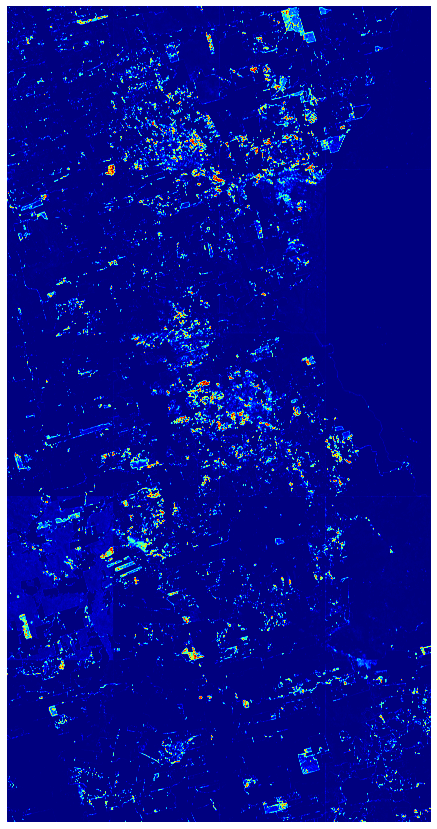

In [707]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

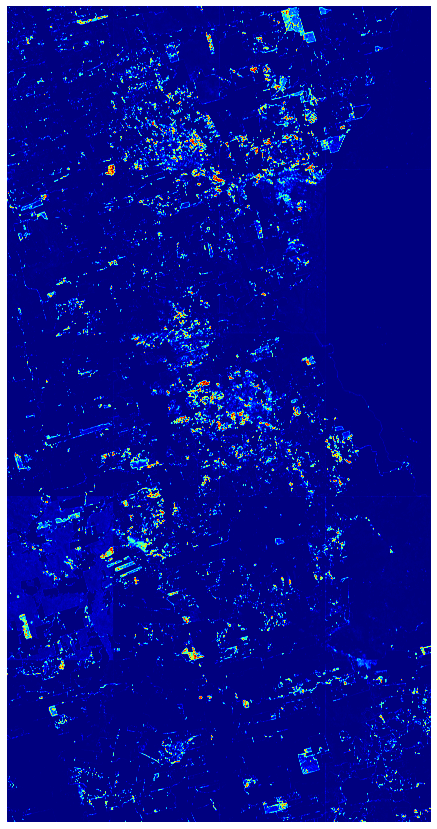

In [708]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

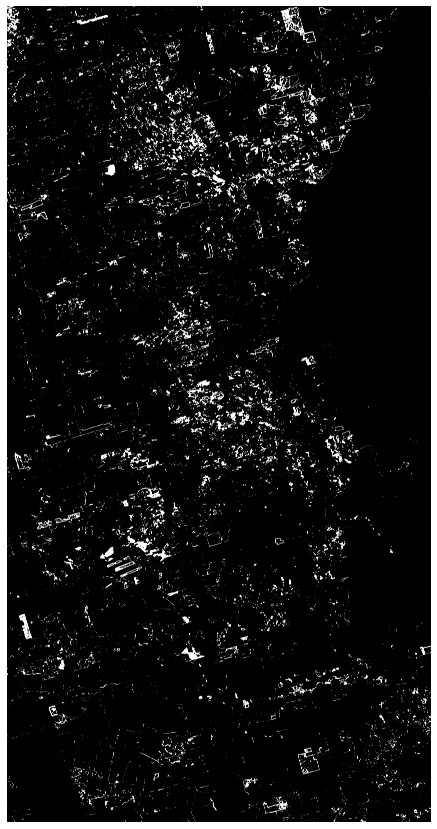

In [709]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [710]:
# np.unique(label_mask_val_valid, return_counts=True)

In [711]:
'''
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)
'''


'\nimportlib.reload(_metrics)\n\nthreshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]\n\nloadThresholdMetrics = False\nif loadThresholdMetrics == False:\n        # threshold_list_val = [0.1]\n        # y_test\n        ic(uncertainty_val.shape, label_mask_val_valid.shape)\n        importlib.reload(_metrics)\n\n        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, \n                label_mask_val_valid, \n                predicted_val, threshold_list_val)\n\n        ic(metrics_values_val)\n'

In [712]:
'''
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False
'''

"\nm_val = {'precision_L': metrics_values_val[:,0],\n        'recall_L': metrics_values_val[:,1],\n        'recall_Ltotal': metrics_values_val[:,2],\n        'AA': metrics_values_val[:,3],\n        'precision_H': metrics_values_val[:,4],\n        'recall_H': metrics_values_val[:,5]}\n\n\nsave_figures=False\n"

In [713]:
# threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [714]:
'''
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, m_val['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [715]:
'''
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [716]:
'''
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [717]:
'''
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [718]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, label="precision_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, label="precision_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, label="Recall_L")\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, label="Recall_H")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'%\')\nax2.set_xlabel(\'Audit Area (%)\')\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax3.set_xlabel(\'Audit Area (%)\')\nax3.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/recall_precision_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [719]:
'''
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nm_val[\'f1_L\'] = 2*m_val[\'precision_L\']*m_val[\'recall_L\']/(m_val[\'precision_L\']+m_val[\'recall_L\'])\nm_val[\'f1_H\'] = 2*m_val[\'precision_H\']*m_val[\'recall_H\']/(m_val[\'precision_H\']+m_val[\'recall_H\'])\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="f1_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [720]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, \'C0-\', label="Precision Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, \'C0--\', label="Recall Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, \'C1-\', label="Precision High Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, \'C1--\', label="Recall High Uncertainty")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'Precision/recall (%)\')\nax1.set_xlabel(\'Audit Area (%)\')\nax1.set_ylim(ylim)\nax1.set_xlim(xlim)\n\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="F1 Low Uncertainty")\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="F1 High Uncertainty")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'F1 score (%)\')\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylim(ylim)\nax2.set_xlim(xlim)\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), lab